In [ ]:
import pandas as pd
import numpy as np
import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

import timeit
import time


In [ ]:
start = time.time()

usecols = ['CIRCUIT', 'DISTRICT', 'OFFICE', 'ORIGIN', 'FILEDATE',
       'FDATEUSE', 'JURIS', 'NOS', 'RESIDENC',
       'JURY', 'DEMANDED', 'COUNTY', 'PLT', 'DEF', 'TERMDATE', 'TDATEUSE',
       'PROCPROG', 'DISP', 'NOJ', 'AMTREC', 'JUDGMENT',
       'PROSE', 'STATUSCD', 'TAPEYEAR']

chunk = pd.read_csv("/content/drive/MyDrive/cv88on.txt",sep='\t',encoding='cp1252',usecols=usecols,chunksize=50000)
df = pd.concat(chunk)

end = time.time()
print("Read csv with chunks: ",round(end-start,2),"sec")

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: DtypeWarning: Columns (1,2,13) have mixed types.Specify dtype option on import or set low_memory=False.
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: DtypeWarning: Columns (1,13) have mixed types.Specify dtype option on import or set low_memory=False.
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  return func(*

Read csv with chunks:  47.48 sec


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9474444 entries, 0 to 9474443
Data columns (total 24 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   CIRCUIT   int64 
 1   DISTRICT  object
 2   OFFICE    object
 3   ORIGIN    int64 
 4   FILEDATE  object
 5   FDATEUSE  object
 6   JURIS     int64 
 7   NOS       int64 
 8   RESIDENC  int64 
 9   JURY      object
 10  DEMANDED  int64 
 11  COUNTY    int64 
 12  PLT       object
 13  DEF       object
 14  TERMDATE  object
 15  TDATEUSE  object
 16  PROCPROG  int64 
 17  DISP      int64 
 18  NOJ       int64 
 19  AMTREC    int64 
 20  JUDGMENT  int64 
 21  PROSE     int64 
 22  STATUSCD  object
 23  TAPEYEAR  int64 
dtypes: int64(14), object(10)
memory usage: 1.7+ GB


In [ ]:
## Lower memory size by downcasting

def downcast_dtype(df):
  print("Dataframe Info before:\n")
  df.info(verbose=False)
  float_cols = df.select_dtypes('float').columns
  df[float_cols] = df[float_cols].apply(pd.to_numeric, downcast='float')

  int_cols = df.select_dtypes('integer').columns
  df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast='integer')
  print("\n\nDataframe Info after:\n")
  df.info(verbose=False)

downcast_dtype(df)


Dataframe Info before:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9474444 entries, 0 to 9474443
Columns: 24 entries, CIRCUIT to TAPEYEAR
dtypes: int64(14), object(10)
memory usage: 1.7+ GB


Dataframe Info after:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9474444 entries, 0 to 9474443
Columns: 24 entries, CIRCUIT to TAPEYEAR
dtypes: int16(4), int32(1), int8(9), object(10)
memory usage: 912.6+ MB


In [ ]:
def replace_values_from_dataset(df,values,newvalues):
  for value in values:
    for i in range(len(df.columns)):
      (df[df.columns[i]]).replace(values,newvalues,inplace=True)

replace_values_from_dataset(df,['-8',-8],np.nan)

In [ ]:
def replace_values_from_column(df,columns,values,newvalue):
  for i in range(0,len(values)):
    df[columns].replace(values[i],newvalue,inplace=True)

replace_values_from_column(df,"JUDGMENT",(4,0),np.nan)
replace_values_from_column(df,"TAPEYEAR",2099,np.nan)

'''
TypeError: 'int' object is not iterable
'''

In [ ]:
df = df[df.TAPEYEAR != 2099]

In [ ]:
def get_column_stats(column):
  val_counts = df[column].value_counts().describe()
  nunique = df[column].nunique()
  unique = df[column].unique()
  print("\033[1m Number of Unique Values: \033[0m",nunique, "\n\n \033[1m Unique Values: \033[0m",unique, "\n\n \033[1m Description of Column:\033[0m", val_counts, )
  print("\n| \033[1m", val_counts.index[4], "of", column,"column's data appear in", int(val_counts[4].round()), "rows at most \033[0m" )
  print("\n| \033[1m", val_counts.index[5], "of", column,"column's data appear in", int(val_counts[5].round()), "rows at most \033[0m" )


In [ ]:
cols_get_stats = ['DEMANDED']
for cols in cols_get_stats:
  get_column_stats(cols)

 Number of Unique Values:  7355 

  Unique Values:  [      nan 1.000e+00 0.000e+00 ... 9.555e+03 4.297e+03 6.815e+03] 

  Description of Column: count    7.355000e+03
mean     1.146648e+03
std      7.719085e+04
min      1.000000e+00
25%      1.000000e+00
50%      3.000000e+00
75%      1.300000e+01
max      6.611765e+06
Name: DEMANDED, dtype: float64

|  25% of DEMANDED column's data appear in 1 rows at most 

|  50% of DEMANDED column's data appear in 3 rows at most 


In [ ]:
df["DEMANDED"].value_counts()

0.0       6611765
75.0       190644
9999.0     181403
50.0       120319
1000.0      66189
           ...   
5881.0          1
5871.0          1
5870.0          1
5863.0          1
5577.0          1
Name: DEMANDED, Length: 7355, dtype: int64

In [ ]:
df.tail()

,CIRCUIT,DISTRICT,OFFICE,ORIGIN,FILEDATE,FDATEUSE,JURIS,NOS,RESIDENC,JURY,DEMANDED,COUNTY,PLT,DEF,TERMDATE,TDATEUSE,PROCPROG,DISP,NOJ,AMTREC,JUDGMENT,PROSE,STATUSCD,TAPEYEAR
9474415,11,3J,6,5.0,06/23/2021,06/01/2021,3.0,530,NaN,N,0.0,88888,FULCHER,"CALDWELL, ET AL",08/31/2021,08/01/2021,1.0,17.0,0.0,0.0,4.0,1.0,L,2021
9474418,11,3J,6,1.0,07/08/2021,07/01/2021,3.0,555,NaN,N,999.0,13031,MCKENDRICK,"BULLOCH COUNTY, ET AL",08/10/2021,08/01/2021,1.0,14.0,0.0,0.0,0.0,1.0,L,2021
9474420,11,3J,6,1.0,07/15/2021,07/01/2021,3.0,555,NaN,N,0.0,13267,WIMBERLY,"BOBBIT, ET AL",09/10/2021,09/01/2021,2.0,14.0,0.0,0.0,0.0,1.0,L,2021
9474432,11,3J,6,1.0,08/19/2021,08/01/2021,3.0,555,NaN,N,0.0,13267,BUCKNER,"SUPREME COURT OF GEORGI, ET AL",09/30/2021,09/01/2021,1.0,0.0,0.0,0.0,0.0,1.0,L,2021
9474440,11,3J,6,1.0,09/07/2021,09/01/2021,3.0,530,NaN,N,0.0,13267,ALFORD,CHAMBERS,09/08/2021,09/01/2021,1.0,0.0,0.0,0.0,0.0,1.0,L,2021


## Data Collection Timeline throughout the years:

In [ ]:
df_timeline = df.groupby("TAPEYEAR")
df_timeline = df_timeline.count()
df_timeline_cumm = df_timeline.cumsum(axis = 0)

In [ ]:
df_timeline_cumm

,CIRCUIT,DISTRICT,OFFICE,ORIGIN,FILEDATE,FDATEUSE,JURIS,NOS,RESIDENC,JURY,DEMANDED,COUNTY,PLT,DEF,TERMDATE,TDATEUSE,PROCPROG,DISP,NOJ,AMTREC,JUDGMENT,PROSE,STATUSCD
TAPEYEAR,,,,,,,,,,,,,,,,,,,,,,,
1988,238753,238753,238753,238753,238753,238753,238753,238753,67364,15546,106653,238753,238745,238252,238752,238753,238753,238753,74569,45552,76269,0,0
1989,473972,473972,473972,473971,473972,473972,473972,473972,132331,32796,219310,473972,473069,471617,473971,473972,473972,473972,153567,113749,157294,0,0
1990,687894,687894,687894,687893,687894,687894,687894,687894,190076,52634,341953,687894,686030,683248,687893,687894,687894,687894,225303,214033,229404,0,0
1991,899607,899607,899607,899606,899607,899607,899607,899607,244452,68727,488349,899607,896445,892868,899606,899607,899607,899607,293004,362154,295028,0,0
1992,1202814,1202814,1202814,1202813,1202814,1202814,1202813,1202814,328065,84073,791556,1202814,1199127,1193903,1202813,1202814,1202814,1202814,395660,665361,389826,0,0
1993,1430409,1430409,1430409,1430408,1430409,1430409,1430408,1430409,379350,92987,1019151,1430409,1426485,1420041,1430408,1430409,1430409,1430409,471483,892956,460536,0,0
1994,1658769,1658769,1658769,1658768,1658769,1658769,1658768,1658769,432993,105397,1247511,1658769,1654701,1647199,1658768,1658769,1658769,1658769,542805,1121316,525579,0,0
1995,1888589,1888589,1888589,1888471,1888589,1888589,1888588,1888589,478810,108952,1477331,1888589,1884372,1876003,1888588,1888589,1888589,1888589,616592,1351136,592008,0,0
1996,2138976,2138976,2138976,2138426,2138976,2138976,2138975,2138976,526347,110354,1727718,2138976,2134603,2125356,2138973,2138974,2138974,2138974,692870,1601521,660203,248289,0


(array([1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
        1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
        2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
        2021]), <a list of 34 Text major ticklabel objects>)

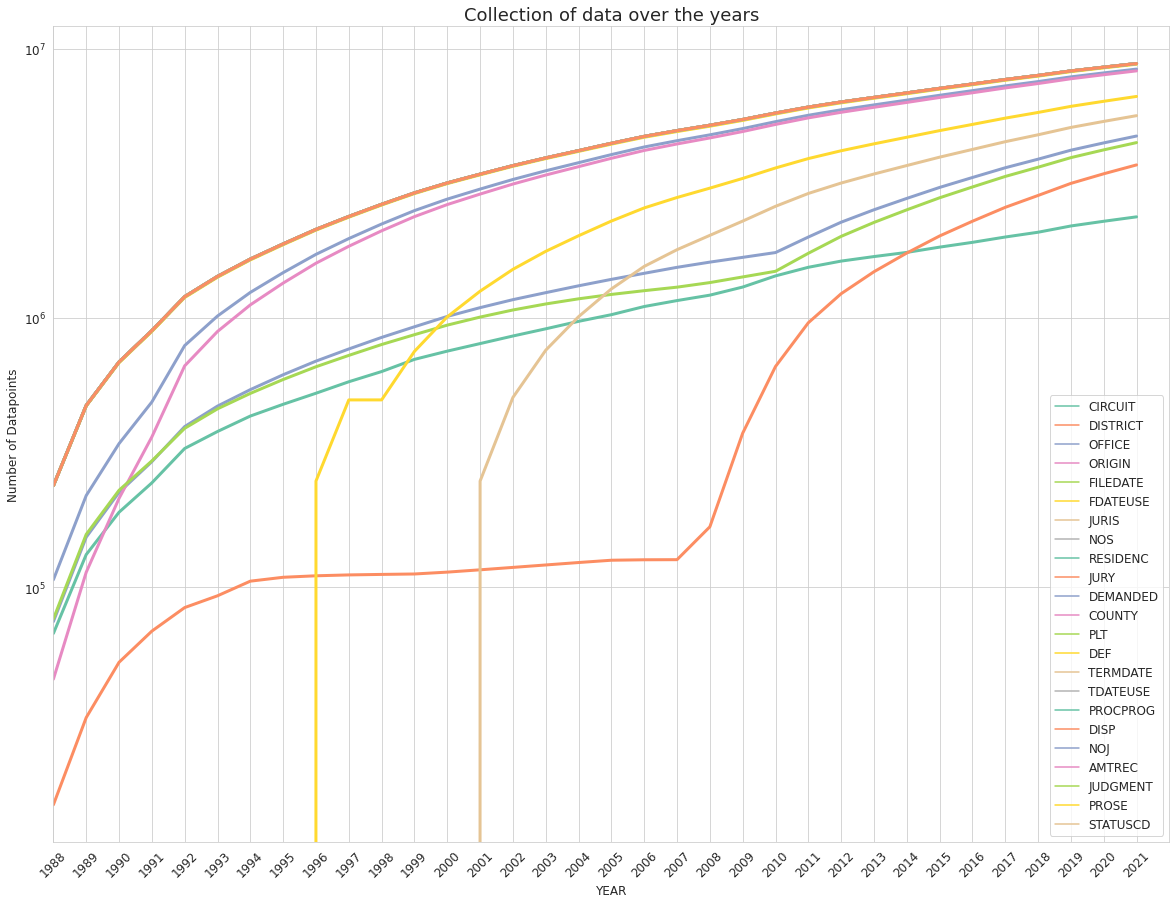

In [ ]:
plt.figure(figsize=(20,15))
ax = sns.lineplot(data=df_timeline_cumm,dashes=False,linewidth=3,palette='Set2')
sns.set_style('white')

## Labels and Title
ax.set(xlabel="YEAR",ylabel="Number of Datapoints",title="Collection of data over the years")

## Axes limits, ticks and Scale
ax.set(xlim=(1988,2022) , xticks=(range(1988,2022)),yscale='log')
#ax.set(ylim=(0,10000000) , yticks=[0,10000000])
plt.xticks(rotation=45) #ax.set do not work as it needs xticks names too

In [ ]:
df.replace({"JUDGMENT":{0:np.nan,4:np.nan}},inplace=True)
df.head()


,CIRCUIT,DISTRICT,OFFICE,ORIGIN,JURIS,NOS,RESIDENC,JURY,DEMANDED,COUNTY,PLT,DEF,TDATEUSE,PROCPROG,DISP,AMTREC,DJOINED,PROSE,STATUSCD,TAPEYEAR,LABEL,CASEDAYS
0,0,90,1,4.0,3.0,440,NaN,NaN,NaN,0,CAMPBELL,RODGERS,06/01/1988,6.0,9.0,NaN,NaN,NaN,NaN,1988,13.0,5233.0
1,0,90,1,4.0,2.0,890,NaN,NaN,NaN,0,MCKENZIE ETAL,MCCORMICK ETAL,04/01/1988,4.0,17.0,518.0,01/20/1988,NaN,NaN,1988,11.0,5450.0
4,0,90,1,2.0,2.0,550,NaN,NaN,NaN,0,PITTS,BELL,12/01/1987,12.0,6.0,NaN,NaN,NaN,NaN,1988,20.0,3100.0
5,0,90,1,1.0,2.0,442,NaN,NaN,NaN,0,MILLER ETAL,USA ETAL,04/01/1988,8.0,9.0,NaN,NaN,NaN,NaN,1988,20.0,3133.0
8,0,90,1,4.0,2.0,440,NaN,NaN,0.0,99999,OBADELE,MCCALL,04/01/1988,4.0,6.0,0.0,NaN,NaN,NaN,1988,20.0,56.0


In [ ]:
def replace_value_from_ncolumns(data,columns,value,newvalue):
  for cols in columns:
    data.replace({cols:{value:newvalue}}, inplace=True)

replace_value_from_ncolumns(df,("DEMANDED","AMTREC"),9999,np.nan)

In [ ]:
df["LABEL"] = df["NOJ"] + (df["JUDGMENT"]*10)
to_drop = ['NOJ','JUDGMENT']
df.drop(to_drop, inplace=True,axis=1)
df.head()

,CIRCUIT,DISTRICT,OFFICE,ORIGIN,FILEDATE,FDATEUSE,JURIS,NOS,RESIDENC,JURY,DEMANDED,COUNTY,PLT,DEF,TERMDATE,TDATEUSE,PROCPROG,DISP,AMTREC,DJOINED,PROSE,STATUSCD,TAPEYEAR,LABEL
0,0,90,1,4.0,07/21/1971,07/01/1971,3.0,440,NaN,NaN,NaN,0,CAMPBELL,RODGERS,11/17/1985,06/01/1988,6.0,9.0,NaN,NaN,NaN,NaN,1988,13.0
1,0,90,1,4.0,05/17/1973,02/01/1983,2.0,890,NaN,NaN,NaN,0,MCKENZIE ETAL,MCCORMICK ETAL,04/18/1988,04/01/1988,4.0,17.0,518.0,01/20/1988,NaN,NaN,1988,11.0
2,0,90,1,4.0,01/31/1985,06/01/1985,2.0,440,NaN,NaN,NaN,0,HOBSON ETAL,WILSON ETAL,03/21/1988,03/01/1988,10.0,13.0,NaN,NaN,NaN,NaN,1988,NaN
3,0,90,1,3.0,09/19/1984,05/01/1986,2.0,442,NaN,NaN,NaN,0,SEGAR,LEVI,10/19/1985,06/01/1988,10.0,13.0,NaN,NaN,NaN,NaN,1988,NaN
4,0,90,1,2.0,06/15/1979,06/01/1979,2.0,550,NaN,NaN,NaN,0,PITTS,BELL,12/10/1987,12/01/1987,12.0,6.0,NaN,NaN,NaN,NaN,1988,20.0


In [ ]:
df["TERMDATE"]= pd.to_datetime(df["TERMDATE"])
df["FILEDATE"]= pd.to_datetime(df["FILEDATE"])
df["CASEDAYS"] = (df["TERMDATE"]-df["FILEDATE"]).dt.days
to_drop = ['TERMDATE','FILEDATE','FDATEUSE']
df.drop(to_drop, inplace=True,axis=1)
df.head()

,CIRCUIT,DISTRICT,OFFICE,ORIGIN,JURIS,NOS,RESIDENC,JURY,DEMANDED,COUNTY,PLT,DEF,TDATEUSE,PROCPROG,DISP,AMTREC,DJOINED,PROSE,STATUSCD,TAPEYEAR,LABEL,CASEDAYS
0,0,90,1,4.0,3.0,440,NaN,NaN,NaN,0,CAMPBELL,RODGERS,06/01/1988,6.0,9.0,NaN,NaN,NaN,NaN,1988,13.0,5233.0
1,0,90,1,4.0,2.0,890,NaN,NaN,NaN,0,MCKENZIE ETAL,MCCORMICK ETAL,04/01/1988,4.0,17.0,518.0,01/20/1988,NaN,NaN,1988,11.0,5450.0
2,0,90,1,4.0,2.0,440,NaN,NaN,NaN,0,HOBSON ETAL,WILSON ETAL,03/01/1988,10.0,13.0,NaN,NaN,NaN,NaN,1988,NaN,1145.0
3,0,90,1,3.0,2.0,442,NaN,NaN,NaN,0,SEGAR,LEVI,06/01/1988,10.0,13.0,NaN,NaN,NaN,NaN,1988,NaN,395.0
4,0,90,1,2.0,2.0,550,NaN,NaN,NaN,0,PITTS,BELL,12/01/1987,12.0,6.0,NaN,NaN,NaN,NaN,1988,20.0,3100.0


In [ ]:
missing_value_count = df.isnull().sum()
total_cells = np.product(df.shape)
total_missing = missing_value_count.sum()
total_percentage_missing = (total_missing/total_cells)*100
percent_missing = round(df.isnull().mean()*100,1)
missing_value_count = missing_value_count.to_frame().merge(percent_missing.to_frame(), left_index=True, right_index=True)
print("Missing Values Count:")
print(missing_value_count)
print("\nTotal Percentage of missing data:",round(total_percentage_missing,2),'%')

Missing Values Count:
              0_x   0_y
CIRCUIT         0   0.0
DISTRICT        0   0.0
OFFICE          0   0.0
ORIGIN        550   0.0
JURIS           1   0.0
NOS             0   0.0
RESIDENC  6463161  73.1
JURY      5130193  58.0
DEMANDED   411258   4.6
COUNTY          0   0.0
PLT         23836   0.3
DEF         50404   0.6
TDATEUSE        5   0.0
PROCPROG        5   0.0
DISP            5   0.0
AMTREC     537458   6.1
DJOINED   5585820  63.2
PROSE     2170904  24.5
STATUSCD  3183081  36.0
TAPEYEAR        0   0.0
LABEL     6834606  77.3
CASEDAYS        6   0.0

Total Percentage of missing data: 15.62 %


In [ ]:
missings_df={}
for key in df.columns:
    if df[key].isnull().sum() > 0:
        missings_df[key]=(df[key].isnull().sum()  /  len(df[key]) ) * 100

#Create missing values dataframe
missings_df=pd.DataFrame(missings_df,index=['MissingValues']).T.sort_values(by='MissingValues',ascending=False)

Text(0.5, 1.0, 'Percentage of missing values per column')

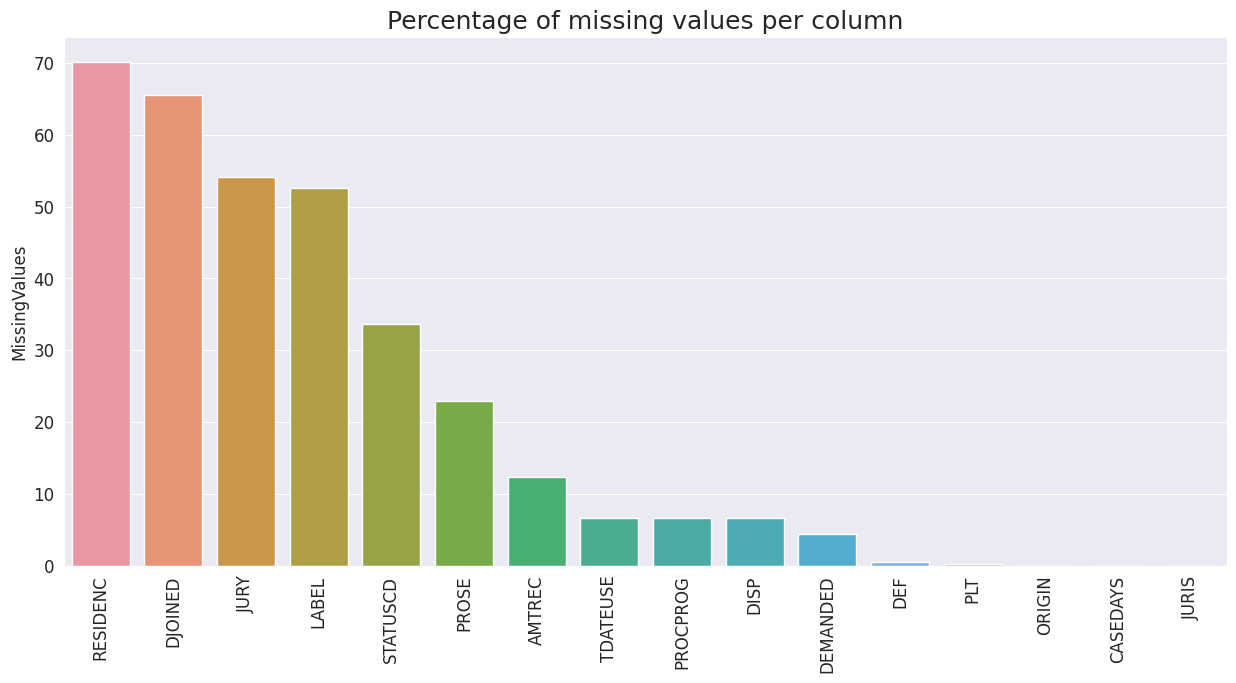

In [ ]:
#Plotting the percentage of missing values per column
plt.figure(figsize=(15,7),dpi=100)
plt.xticks(rotation=90)
sns.barplot(y=missings_df.MissingValues,x=missings_df.index, orient='v').set_title('Percentage of missing values per column')

In [ ]:
#Sort transposed describe() by count
df.describe(include='object').T.sort_values(by=['count']).head(10)

,count,unique,top,freq
DJOINED,3259044,14615,11/03/2006,2915
JURY,4342350,33,N,1886103
STATUSCD,6291363,2,L,5661775
TDATEUSE,8844851,411,05/01/2005,42477
DEF,9423540,2519173,"3M COMPANY, ET AL",294018
PLT,9450218,1827840,USA,245775
DISTRICT,9474444,178,13,506158
OFFICE,9474444,23,2,2655985


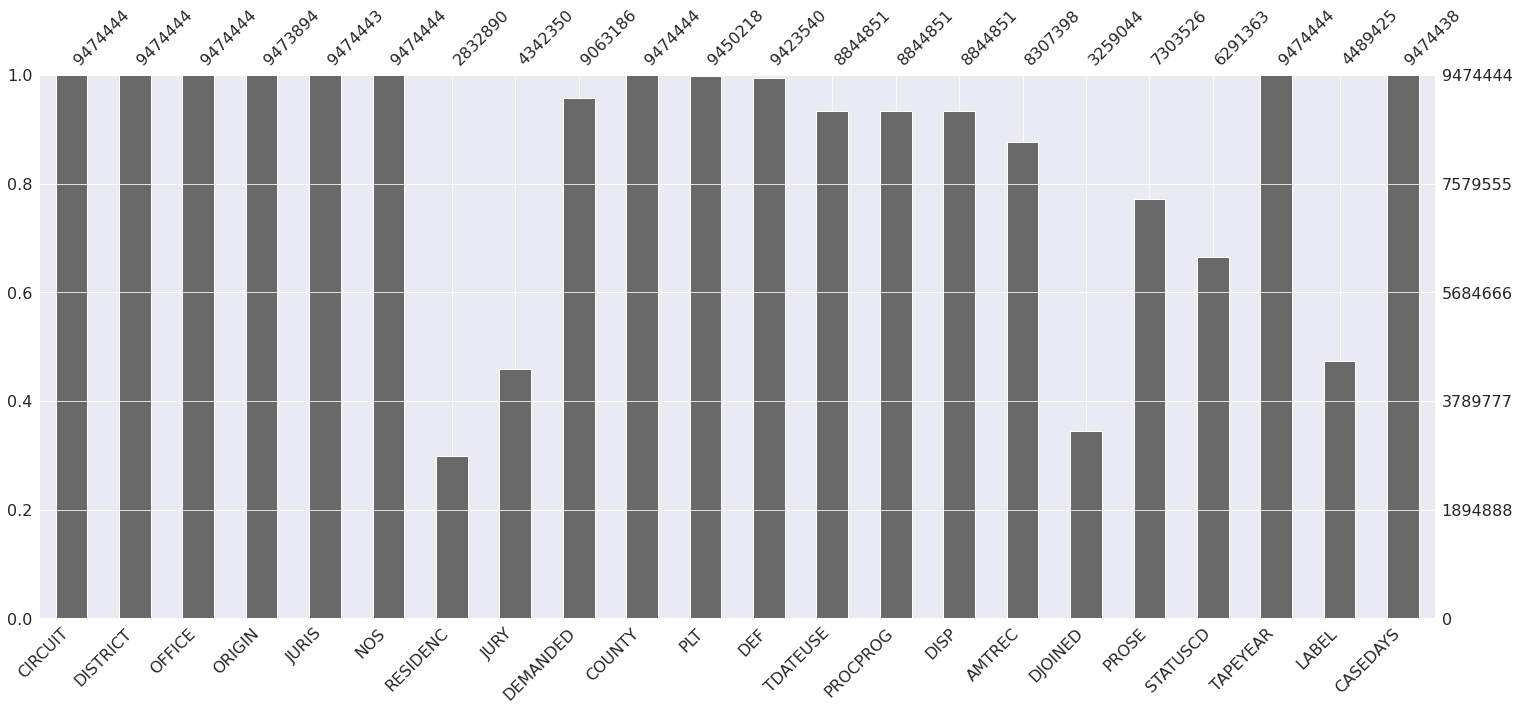

In [ ]:
msno.bar(df)

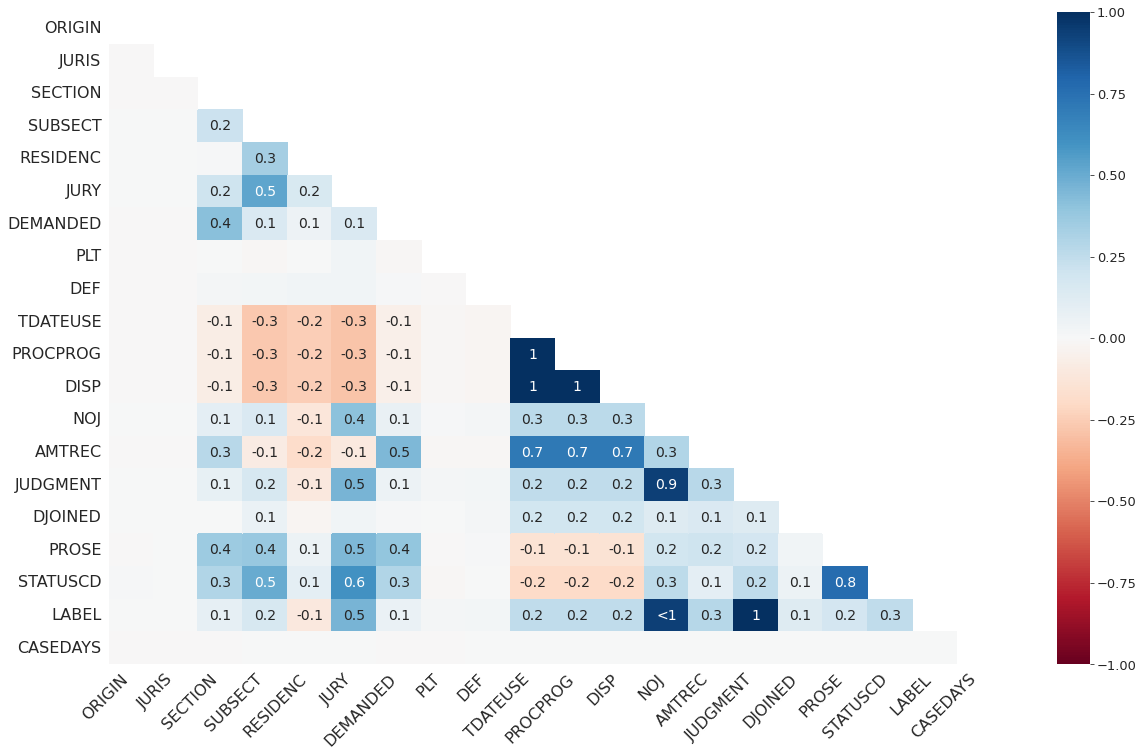

In [ ]:
msno.heatmap(df)
'''
Heatmap:
The heatmap is used to identify correlations of the nullity between each of the different columns. In other words, it can be used to identify if there is a relationship in the presence of null values between each of the columns.
Values close to positive 1 indicate that the presence of null values in one column is correlated with the presence of null values in another column.
Values close to negative 1 indicate that the presence of null values in one column is anti-correlated with the presence of null values in another column. In other words, when null values are present in one column, there are data values present in the other column, and vice versa.
Values close to 0, indicate there is little to no relationship between the presence of null values in one column compared to another.
There are a number of values that show as <-1. This indicates that the correlation is very close to being 100% negative.
'''

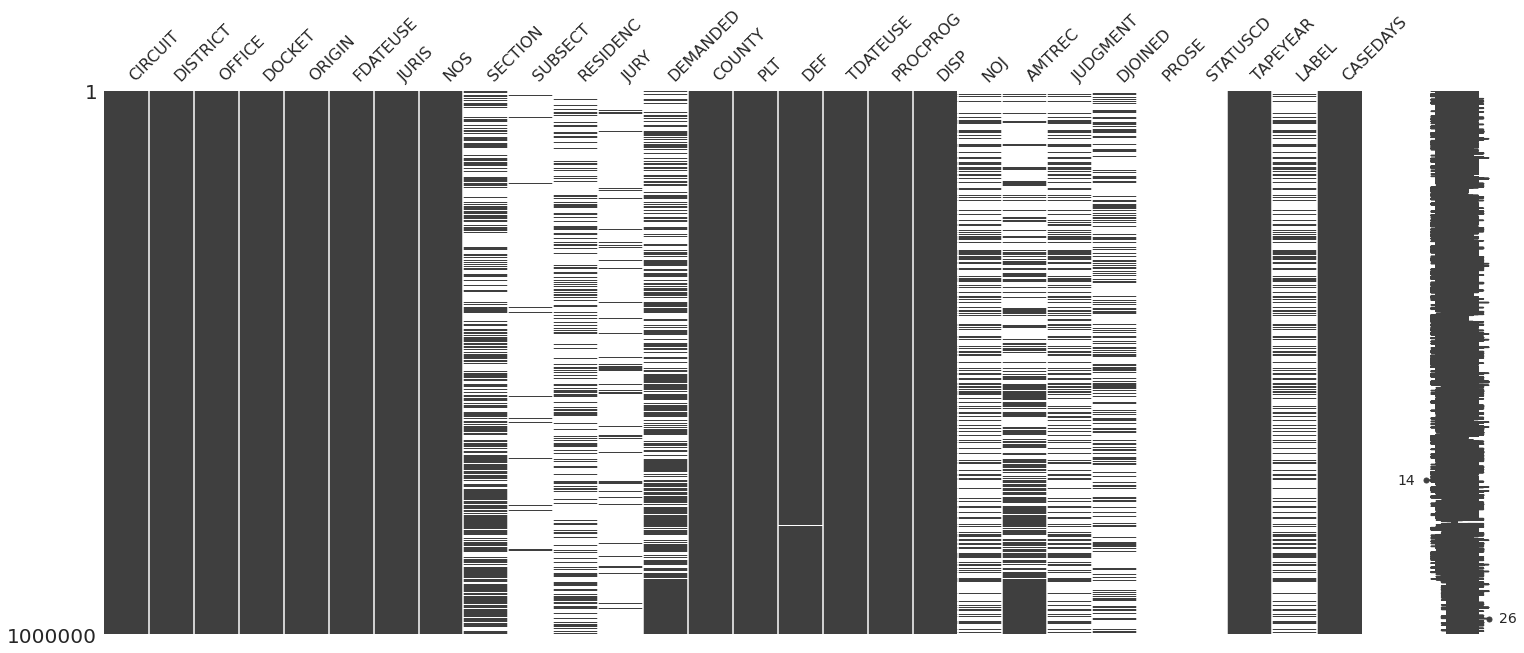

In [ ]:
msno.matrix(df[0:1000000])


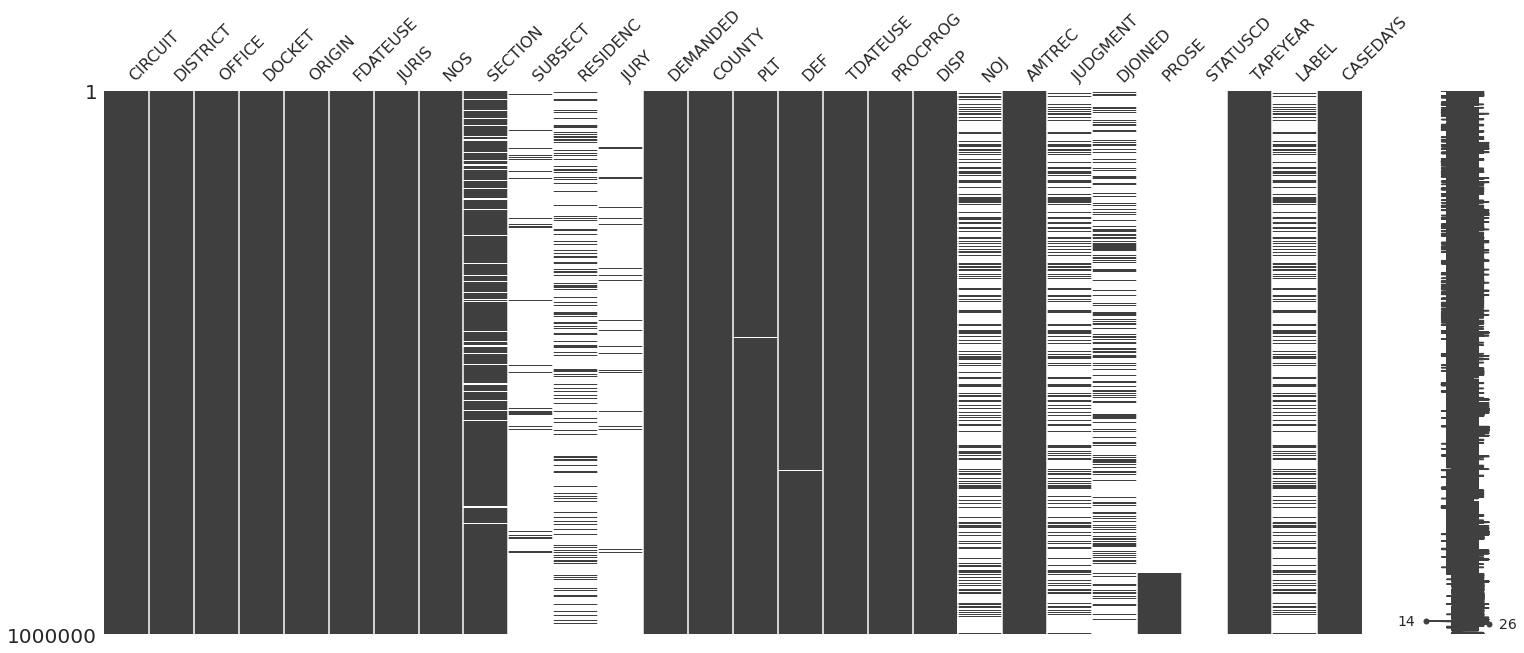

In [ ]:
msno.matrix(df[1000000:2000000])

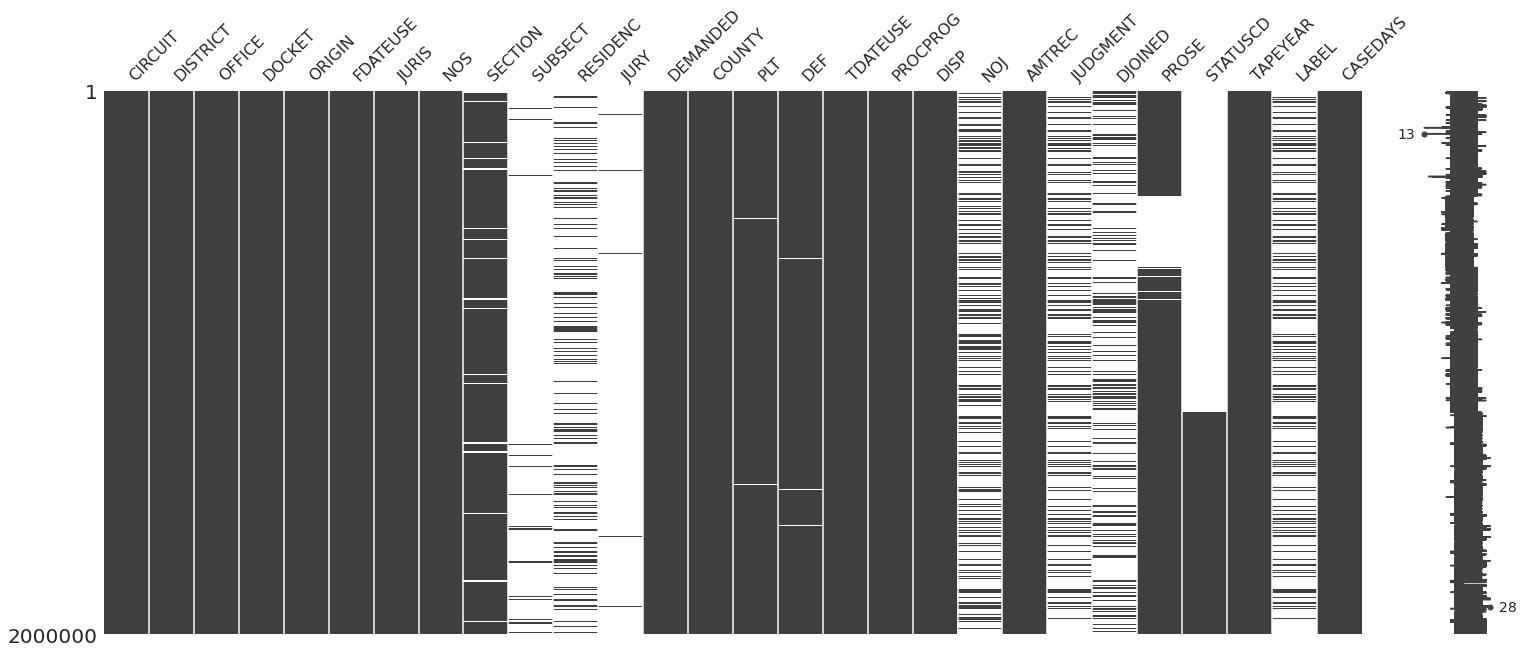

In [ ]:
msno.matrix(df[2000000:4000000])

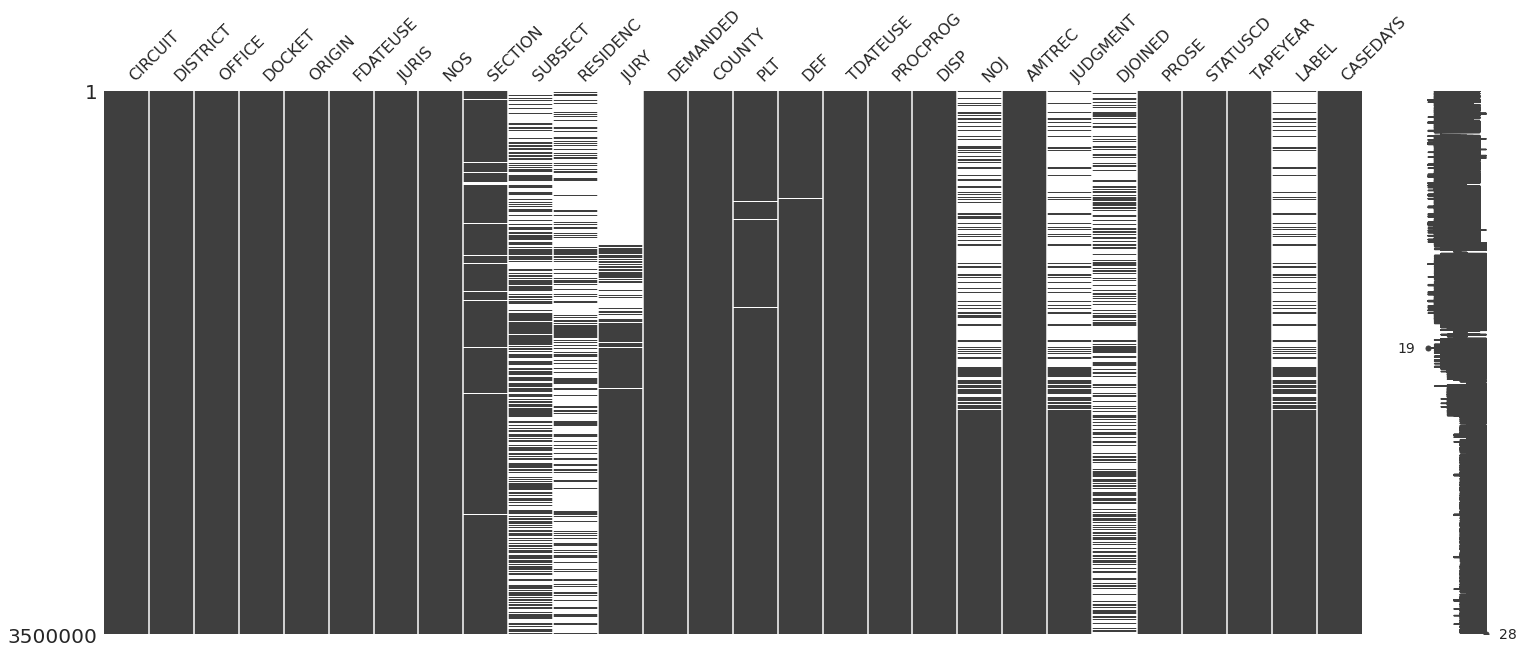

In [ ]:
msno.matrix(df[4000000:7500000])

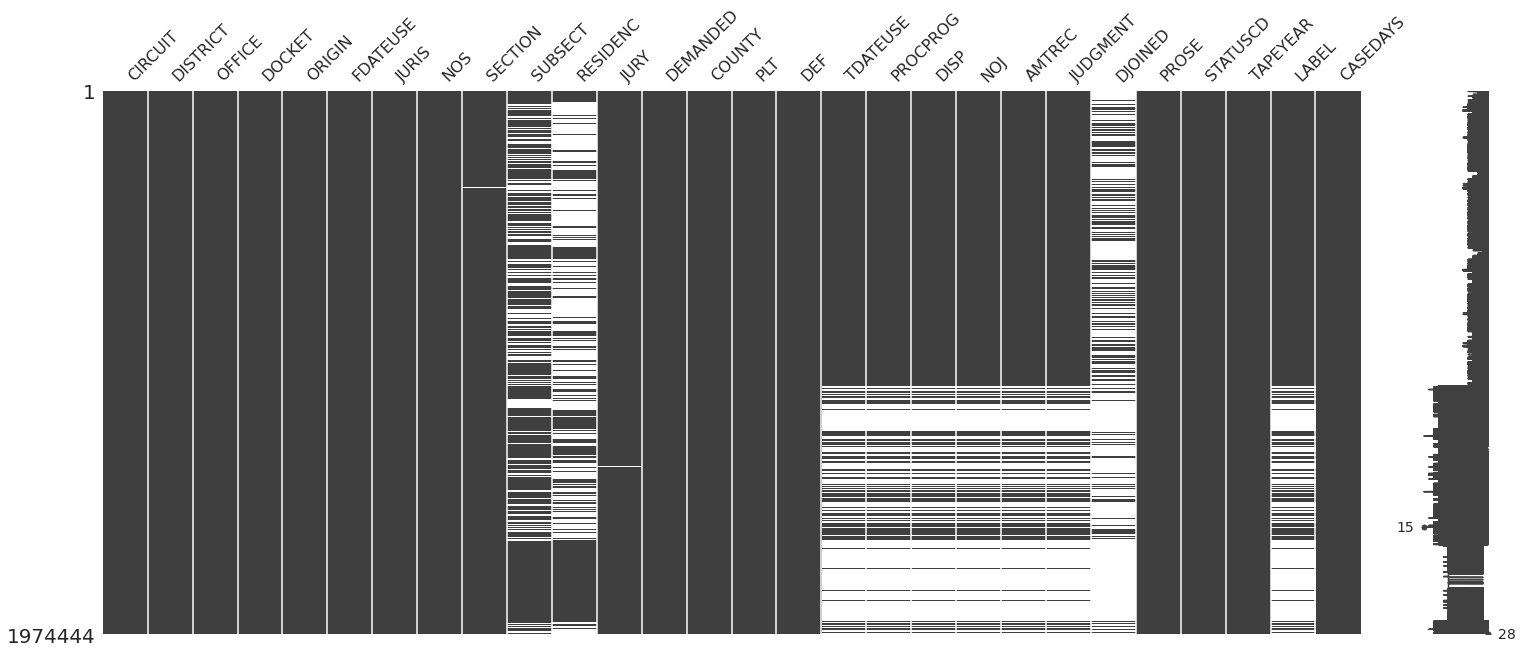

In [ ]:
msno.matrix(df[7500000:])

In [ ]:
print("Old Shape:",df.shape)
df.dropna(subset=["LABEL"],inplace=True)
#threshold = len(df)*0.25
#df.dropna(axis=1,thresh=threshold,inplace=True)
#df = df.dropna(how='any',axis=0)
print("New Shape:",df.shape)

Old Shape: (8844856, 22)
New Shape: (2010250, 22)


In [ ]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

missing_zero_values_table(df)

Your selected dataframe has 22 columns and 2010250 Rows.
There are 10 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
RESIDENC,7,1721768,85.6,1721775,85.6,float64
JURY,0,1324480,65.9,1324480,65.9,object
DJOINED,0,1240096,61.7,1240096,61.7,object
STATUSCD,0,932651,46.4,932651,46.4,object
PROSE,811993,658743,32.8,1470736,73.2,float64
DEMANDED,1398645,130062,6.5,1528707,76.0,float64
AMTREC,1456521,112310,5.6,1568831,78.0,float64
DEF,0,8107,0.4,8107,0.4,object
PLT,0,4296,0.2,4296,0.2,object
ORIGIN,0,215,0.0,215,0.0,float64


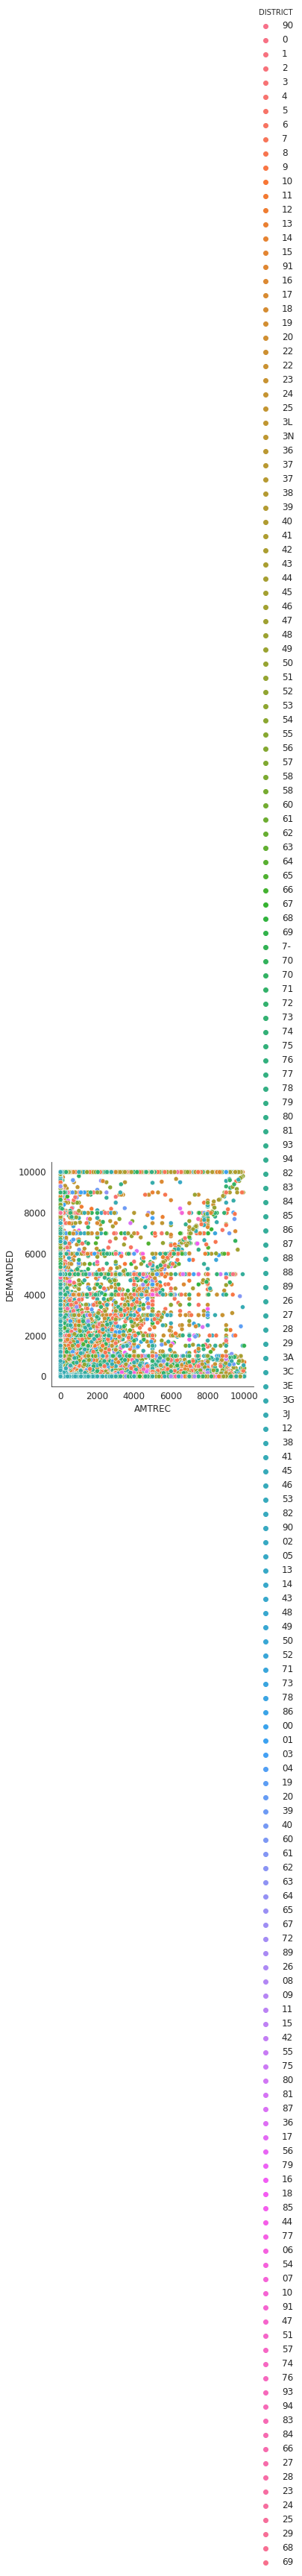

In [ ]:
sns.relplot(data=df,x="AMTREC",y="DEMANDED")

In [ ]:
df.to_csv("LLrawdata.csv")

## Imputation

In [ ]:
df.head()

,CIRCUIT,DISTRICT,OFFICE,ORIGIN,JURIS,NOS,JURY,DEMANDED,COUNTY,PLT,DEF,TDATEUSE,PROCPROG,DISP,AMTREC,DJOINED,PROSE,STATUSCD,TAPEYEAR,LABEL,CASEDAYS
3196641,2,06,5,1.0,3.0,893,P,0.0,88888,ITT COMMERCIAL,HARSCO CORPORATION,03/01/2001,9.0,5.0,3700.0,05/27/1992,0.0,L,2001.0,12.0,3548.0
3197433,2,06,9,4.0,3.0,550,P,9999.0,36015,JERMOSEN,COUGHLIN,01/01/2001,4.0,6.0,0.0,12/17/1990,1.0,L,2001.0,20.0,4080.0
3300030,6,45,4,1.0,2.0,340,N,0.0,26099,"SAGAN, ET AL",USA,09/01/2001,4.0,6.0,0.0,04/27/1999,0.0,L,2001.0,20.0,935.0
3308479,6,48,3,1.0,2.0,362,N,0.0,88888,WIKLE,USA,08/01/2001,5.0,17.0,0.0,09/26/1996,0.0,L,2001.0,20.0,1852.0
3341918,8,65,4,1.0,1.0,850,N,0.0,29510,SECURITIES AND EXCHANGE,"EDWARD L. MORRIS,",11/01/2000,8.0,9.0,0.0,03/08/1994,2.0,L,2001.0,15.0,3256.0


## NLP

In [ ]:
df["PLT_ETAL"] = df["PLT"].str.contains("ETAL|ET AL")
df["DEF_ETAL"] = df["DEF"].str.contains("ETAL|ET AL")

In [ ]:
def get_orgs(doc):
    org_list = []
    for entity in doc.ents:
        if entity.label_ == 'ORG':
            org_list.append(entity.text)
    # if organization is identified more than once it will appear multiple times in list
    # we use set() to remove duplicates then convert back to list
    org_list = list(set(org_list))
    return org_list 

def preprocess_pipe(text):
    preproc_pipe = []
    for doc in nlp.pipe(text, batch_size=100000, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]):
        preproc_pipe.append(get_orgs(doc))
    return preproc_pipe

In [ ]:
%%time
import spacy
nlp = spacy.load('en_core_web_sm')

"""
def get_entity_pipeline(column):
  for cols in column:
    df[cols+'ENT'] = preprocess_pipe(df[cols])
"""

df['PLT_ORG'] = preprocess_pipe(df['PLT'])
df['DEF_ORG'] = preprocess_pipe(df['DEF'])

CPU times: user 11min 36s, sys: 17.3 s, total: 11min 53s
Wall time: 11min 53s


In [ ]:
df.head()

,CIRCUIT,DISTRICT,OFFICE,ORIGIN,JURIS,NOS,SECTION,JURY,DEMANDED,COUNTY,PLT,DEF,TDATEUSE,PROCPROG,DISP,AMTREC,DJOINED,PROSE,STATUSCD,TAPEYEAR,LABEL,CASEDAYS,PLT_ETAL,DEF_ETAL,PLT_ORG,DEF_ORG,PLT_ORG_FLAG,DEF_ORG_FLAG,PLT_ORG1
3196641,2,06,5,1.0,3.0,893,6901,P,0.0,88888,ITT COMMERCIAL,HARSCO CORPORATION,03/01/2001,9.0,5.0,3700.0,05/27/1992,0.0,L,2001,12.0,3548.0,False,False,NaN,NaN,True,True,NaN
3197433,2,06,9,4.0,3.0,550,1983,P,9999.0,36015,JERMOSEN,COUGHLIN,01/01/2001,4.0,6.0,0.0,12/17/1990,1.0,L,2001,20.0,4080.0,False,False,NaN,NaN,True,True,NaN
3341918,8,65,4,1.0,1.0,850,77QA,N,0.0,29510,SECURITIES AND EXCHANGE,"EDWARD L. MORRIS,",11/01/2000,8.0,9.0,0.0,03/08/1994,2.0,L,2001,15.0,3256.0,False,False,SECURITIES AND EXCHANGE,NaN,True,True,SECURITIES AND EXCHANGE
3341925,8,65,4,1.0,3.0,442,2000,Y,250.0,29510,HALL,MO HIGHWAY DEPARTMENT,05/01/2001,10.0,5.0,185.0,04/23/2001,0.0,L,2001,12.0,1834.0,False,False,NaN,MO HIGHWAY DEPARTMENT,True,True,NaN
3350668,9,71,3,1.0,4.0,190,1332,P,0.0,88888,BROTHER INT'L,MITSUI O.S.K. LINES,04/01/2001,4.0,17.0,216.0,06/12/2000,0.0,L,2001,12.0,337.0,False,False,NaN,NaN,True,True,NaN


In [ ]:
def remove_brackets_from_column(columns):
  for cols in columns:
    df[cols] = df[cols].str[0]

remove_brackets_from_column(['PLT_ORG','DEF_ORG'])

In [ ]:
df.head()

,CIRCUIT,DISTRICT,OFFICE,ORIGIN,JURIS,NOS,SECTION,JURY,DEMANDED,COUNTY,PLT,DEF,TDATEUSE,PROCPROG,DISP,AMTREC,DJOINED,PROSE,STATUSCD,TAPEYEAR,LABEL,CASEDAYS,PLT_ETAL,DEF_ETAL,PLT_ORG,DEF_ORG,PLT_ORG_FLAG,DEF_ORG_FLAG
3196641,2,06,5,1.0,3.0,893,6901,P,0.0,88888,ITT COMMERCIAL,HARSCO CORPORATION,03/01/2001,9.0,5.0,3700.0,05/27/1992,0.0,L,2001,12.0,3548.0,False,False,[],[],True,True
3197433,2,06,9,4.0,3.0,550,1983,P,9999.0,36015,JERMOSEN,COUGHLIN,01/01/2001,4.0,6.0,0.0,12/17/1990,1.0,L,2001,20.0,4080.0,False,False,[],[],True,True
3341918,8,65,4,1.0,1.0,850,77QA,N,0.0,29510,SECURITIES AND EXCHANGE,"EDWARD L. MORRIS,",11/01/2000,8.0,9.0,0.0,03/08/1994,2.0,L,2001,15.0,3256.0,False,False,[SECURITIES AND EXCHANGE],[],True,True
3341925,8,65,4,1.0,3.0,442,2000,Y,250.0,29510,HALL,MO HIGHWAY DEPARTMENT,05/01/2001,10.0,5.0,185.0,04/23/2001,0.0,L,2001,12.0,1834.0,False,False,[],[MO HIGHWAY DEPARTMENT],True,True
3350668,9,71,3,1.0,4.0,190,1332,P,0.0,88888,BROTHER INT'L,MITSUI O.S.K. LINES,04/01/2001,4.0,17.0,216.0,06/12/2000,0.0,L,2001,12.0,337.0,False,False,[],[],True,True


In [ ]:
categorical_cols = ['CIRCUIT', 'DISTRICT', 'OFFICE', 'ORIGIN', 'JURIS', 'NOS', 'PLT_ETAL', 'DEF_ETAL', 'PLT_ORG_FLAG', 'DEF_ORG_FLAG']
df_cat = df[categorical_cols].copy()
df_cat.nunique()

CIRCUIT          12
DISTRICT         94
OFFICE           23
ORIGIN           13
JURIS             5
NOS             111
PLT_ETAL          2
DEF_ETAL          2
PLT_ORG_FLAG      2
DEF_ORG_FLAG      2
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Count')

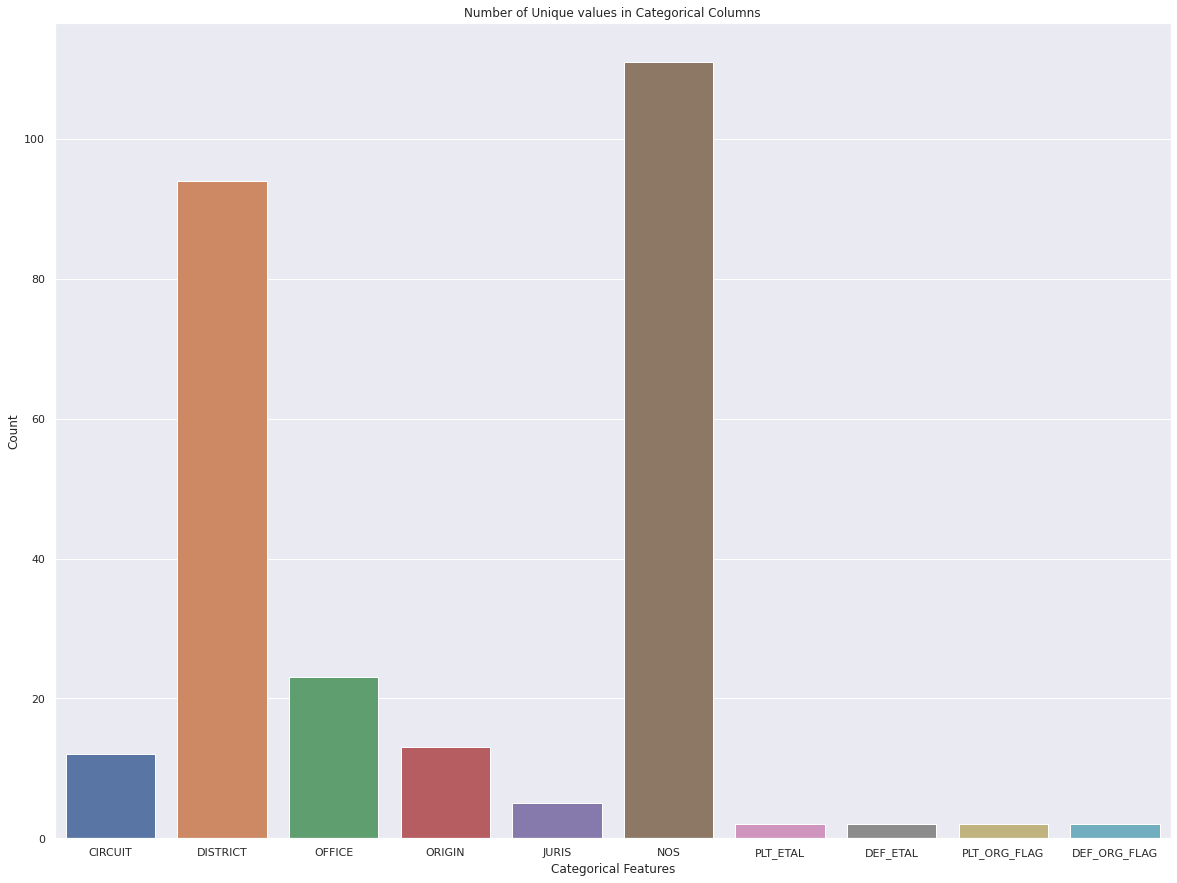

In [ ]:
sns.set(rc={'figure.figsize':(20,15)})
x_uni = df_cat.nunique().index
y_uni = df_cat.nunique().values
ax=sns.barplot(x_uni,y_uni)
##ax.set_yscale("log") ## If values are large
ax.set_title("Number of Unique values in Categorical Columns")
ax.set_xlabel("Categorical Features")
ax.set_ylabel("Count")

In [ ]:
def get_column_stats(column):
  val_counts = df[column].value_counts().describe()
  nunique = df[column].nunique()
  unique = df[column].unique()
  print("\033[1m Number of Unique Values: \033[0m",nunique, "\n\n \033[1m Unique Values: \033[0m",unique, "\n\n \033[1m Description of Column:\033[0m", val_counts, )
  print("\n| \033[1m", val_counts.index[4], "of", column,"column's data appear in", int(val_counts[4].round()), "rows at most \033[0m" )
  print("\n| \033[1m", val_counts.index[5], "of", column,"column's data appear in", int(val_counts[5].round()), "rows at most \033[0m" )


In [ ]:
cols_get_stats = ['AMTREC']
for cols in cols_get_stats:
  get_column_stats(cols)

 Number of Unique Values:  6961 

  Unique Values:  [  nan  518.    0. ... 2762. 2672. 1748.] 

  Description of Column: count    6.961000e+03
mean     2.687476e+02
std      1.747661e+04
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      6.000000e+00
max      1.457032e+06
Name: AMTREC, dtype: float64

|  25% of AMTREC column's data appear in 1 rows at most 

|  50% of AMTREC column's data appear in 2 rows at most 


In [ ]:
df["DEMANDED"].value_counts(ascending=False)

0.0       1398645
1.0         22424
75.0        21769
50.0        19508
2.0         14936
           ...   
3176.0          1
3172.0          1
3164.0          1
3162.0          1
8184.0          1
Name: DEMANDED, Length: 4935, dtype: int64

In [ ]:
def freq_map_encoding(column,percent_remove):
  freq = df[column].value_counts(normalize=True)
  mapping = df[column].map(freq)
  df[column] = df[column].mask(mapping < (percent_remove/100), 'Other')
  return df[column]

## column in format: 'column'
## percent_remove: 1 for 1%

In [ ]:
cols_to_freq_map = ["NOS","DISTRICT","JURY"]
for cols in cols_to_freq_map:
  df[cols] = freq_map_encoding(cols,1)

In [ ]:
df.head()

,CIRCUIT,DISTRICT,OFFICE,ORIGIN,JURIS,NOS,DEMANDED,AMTREC,LABEL,CASEDAYS,PLT_ETAL,DEF_ETAL,PLT_ORG_FLAG,DEF_ORG_FLAG
0,0,90,1,3,2,440,0.0,0.0,13,5233.0,False,False,False,False
1,0,90,1,3,1,890,0.0,518.0,11,5450.0,True,True,True,False
2,0,90,1,1,1,550,0.0,0.0,20,3100.0,False,False,True,False
3,0,90,1,0,1,442,0.0,0.0,20,3133.0,True,True,False,False
4,0,90,1,3,1,440,0.0,0.0,20,56.0,False,False,False,False


In [ ]:
catergorica_cols = ['CIRCUIT', 'DISTRICT', 'OFFICE', 'ORIGIN', 'JURIS', 'NOS', 'PLT_ETAL', 'DEF_ETAL', 'PLT_ORG_FLAG', 'DEF_ORG_FLAG']

numerical_cols = ['DEMANDED', 'AMTREC','CASEDAYS']

label_col = ['LABEL']

In [ ]:
## One-Hot Encoding

df_ohe = pd.get_dummies(df, columns = categorical_cols)

In [ ]:
## Scaling numerical columns

df_ohe[numerical_cols] = MinMaxScaler().fit_transform(df_ohe[numerical_cols])

In [ ]:
## Label Encoding

labelencoder = LabelEncoder()
df_ohe[label_col] = labelencoder.fit_transform(df_ohe[label_col])
df_ohe.head(10)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,DEMANDED,AMTREC,LABEL,CASEDAYS,CIRCUIT_0,CIRCUIT_1,CIRCUIT_2,CIRCUIT_3,CIRCUIT_4,CIRCUIT_5,CIRCUIT_6,CIRCUIT_7,CIRCUIT_8,CIRCUIT_9,CIRCUIT_10,CIRCUIT_11,DISTRICT_1,DISTRICT_5,DISTRICT_7,DISTRICT_8,DISTRICT_9,DISTRICT_12,DISTRICT_13,DISTRICT_15,DISTRICT_16,DISTRICT_17,DISTRICT_18,DISTRICT_20,DISTRICT_22,DISTRICT_30,DISTRICT_31,DISTRICT_32,DISTRICT_35,DISTRICT_39,DISTRICT_41,DISTRICT_42,DISTRICT_43,DISTRICT_45,DISTRICT_47,DISTRICT_48,...,ORIGIN_8,ORIGIN_9,ORIGIN_10,ORIGIN_11,ORIGIN_12,JURIS_0,JURIS_1,JURIS_2,JURIS_3,JURIS_4,NOS_110,NOS_152,NOS_153,NOS_190,NOS_220,NOS_360,NOS_365,NOS_440,NOS_442,NOS_510,NOS_530,NOS_550,NOS_555,NOS_625,NOS_690,NOS_791,NOS_820,NOS_840,NOS_863,NOS_864,NOS_890,NOS_Other,PLT_ETAL_False,PLT_ETAL_True,DEF_ETAL_False,DEF_ETAL_True,PLT_ORG_FLAG_False,PLT_ORG_FLAG_True,DEF_ORG_FLAG_False,DEF_ORG_FLAG_True
0,0.0,0.000000,3,0.195701,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0
1,0.0,0.051805,1,0.202877,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,0
2,0.0,0.000000,7,0.125165,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0
3,0.0,0.000000,7,0.126257,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0
4,0.0,0.000000,7,0.024504,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0
5,0.0,0.000000,7,0.030952,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1
6,0.0,0.000000,7,0.059193,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0
7,0.0,0.000000,7,0.022751,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,1
8,0.0,0.000000,7,0.102579,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0
9,0.0,0.000000,7,0.087665,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1


In [ ]:
def df_column_switch(df, column1, column2):
    i = list(df.columns)
    a, b = i.index(column1), i.index(column2)
    i[b], i[a] = i[a], i[b]
    df = df[i]
    return df

In [ ]:
df_column_switch(df_ohe, 'DEMANDED','LABEL')

,LABEL,AMTREC,DEMANDED,CASEDAYS,CIRCUIT_0,CIRCUIT_1,CIRCUIT_2,CIRCUIT_3,CIRCUIT_4,CIRCUIT_5,CIRCUIT_6,CIRCUIT_7,CIRCUIT_8,CIRCUIT_9,CIRCUIT_10,CIRCUIT_11,DISTRICT_1,DISTRICT_5,DISTRICT_7,DISTRICT_8,DISTRICT_9,DISTRICT_12,DISTRICT_13,DISTRICT_15,DISTRICT_16,DISTRICT_17,DISTRICT_18,DISTRICT_20,DISTRICT_22,DISTRICT_30,DISTRICT_31,DISTRICT_32,DISTRICT_35,DISTRICT_39,DISTRICT_41,DISTRICT_42,DISTRICT_43,DISTRICT_45,DISTRICT_47,DISTRICT_48,...,ORIGIN_8,ORIGIN_9,ORIGIN_10,ORIGIN_11,ORIGIN_12,JURIS_0,JURIS_1,JURIS_2,JURIS_3,JURIS_4,NOS_110,NOS_152,NOS_153,NOS_190,NOS_220,NOS_360,NOS_365,NOS_440,NOS_442,NOS_510,NOS_530,NOS_550,NOS_555,NOS_625,NOS_690,NOS_791,NOS_820,NOS_840,NOS_863,NOS_864,NOS_890,NOS_Other,PLT_ETAL_False,PLT_ETAL_True,DEF_ETAL_False,DEF_ETAL_True,PLT_ORG_FLAG_False,PLT_ORG_FLAG_True,DEF_ORG_FLAG_False,DEF_ORG_FLAG_True
0,3,0.000000,0.000000,0.195701,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0
1,1,0.051805,0.000000,0.202877,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,0
2,7,0.000000,0.000000,0.125165,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0
3,7,0.000000,0.000000,0.126257,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0
4,7,0.000000,0.000000,0.024504,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1997627,7,0.000000,0.030003,0.037302,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1
1997628,3,0.000000,0.007501,0.027116,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,1,0
1997629,7,0.000000,0.000000,0.027612,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0
1997630,7,0.000000,0.000000,0.030390,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1


In [ ]:
## Lower memory size by downcasting

print("Dataframe Info before:\n")
df_ohe.info()
float_cols = df_ohe.select_dtypes('float').columns

int_cols = df_ohe.select_dtypes('integer').columns

df_ohe[float_cols] = df_ohe[float_cols].apply(pd.to_numeric, downcast='float')
df_ohe[int_cols] = df_ohe[int_cols].apply(pd.to_numeric, downcast='integer')
print("\n\nDataframe Info after:\n")
df_ohe.info()

Dataframe Info before:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1997632 entries, 0 to 1997631
Columns: 127 entries, DEMANDED to DEF_ORG_FLAG_True
dtypes: float64(3), int64(1), uint8(123)
memory usage: 295.3 MB


Dataframe Info after:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1997632 entries, 0 to 1997631
Columns: 127 entries, DEMANDED to DEF_ORG_FLAG_True
dtypes: float32(3), int8(124)
memory usage: 259.1 MB


In [ ]:
X_df = df_ohe.loc[:,df_ohe.columns != 'LABEL']
y_df = df_ohe['LABEL']

X_train , X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2,shuffle=True)

In [ ]:
params = {
    'max_depth': 3,
    'objective': 'multi:softmax',  
    'num_class': 21,
    'eval_metric' : 'merror'
}

In [ ]:
## Incrimental XGBoost training
import xgboost as xgb
batch_size = 100000
iterations = 1
model = None
for i in range(iterations):
  print("Iteration:",i,"started!\n\n")
  for start in range(0, len(X_train), batch_size):
      start_time = timeit.default_timer()
      model = xgb.train(params, dtrain=xgb.DMatrix(X_train[start:start+batch_size], y_train[start:start+batch_size]), xgb_model=model)
      stop_time = timeit.default_timer()
      y_pred = model.predict(xgb.DMatrix(X_test))
      predictions = [round(value) for value in y_pred]
      accuracy = accuracy_score(y_test, predictions)
      print("Training for Batch:", int(start/batch_size)+1, "done. Time:",round((stop_time - start_time),1), "seconds.","Accuracy: %.2f%%" % (accuracy*100))      
print("Training Completed!")
y_pred = model.predict(xgb.DMatrix(X_test))

Model training for Iteration: 0 Batch: 1 done. Time: 38.0 seconds.
Model training for Iteration: 0 Batch: 2 done. Time: 41.0 seconds.
Model training for Iteration: 0 Batch: 3 done. Time: 47.4 seconds.
Model training for Iteration: 0 Batch: 4 done. Time: 40.4 seconds.
Model training for Iteration: 0 Batch: 5 done. Time: 43.4 seconds.
Model training for Iteration: 0 Batch: 6 done. Time: 55.4 seconds.
Model training for Iteration: 0 Batch: 7 done. Time: 48.5 seconds.
Model training for Iteration: 0 Batch: 8 done. Time: 49.8 seconds.
Model training for Iteration: 0 Batch: 9 done. Time: 54.8 seconds.
Model training for Iteration: 0 Batch: 10 done. Time: 49.2 seconds.
Model training for Iteration: 0 Batch: 11 done. Time: 60.0 seconds.
Model training for Iteration: 0 Batch: 12 done. Time: 53.9 seconds.
Model training for Iteration: 0 Batch: 13 done. Time: 55.8 seconds.
Model training for Iteration: 0 Batch: 14 done. Time: 56.9 seconds.
Model training for Iteration: 0 Batch: 15 done. Time: 65.

In [ ]:
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 78.12%


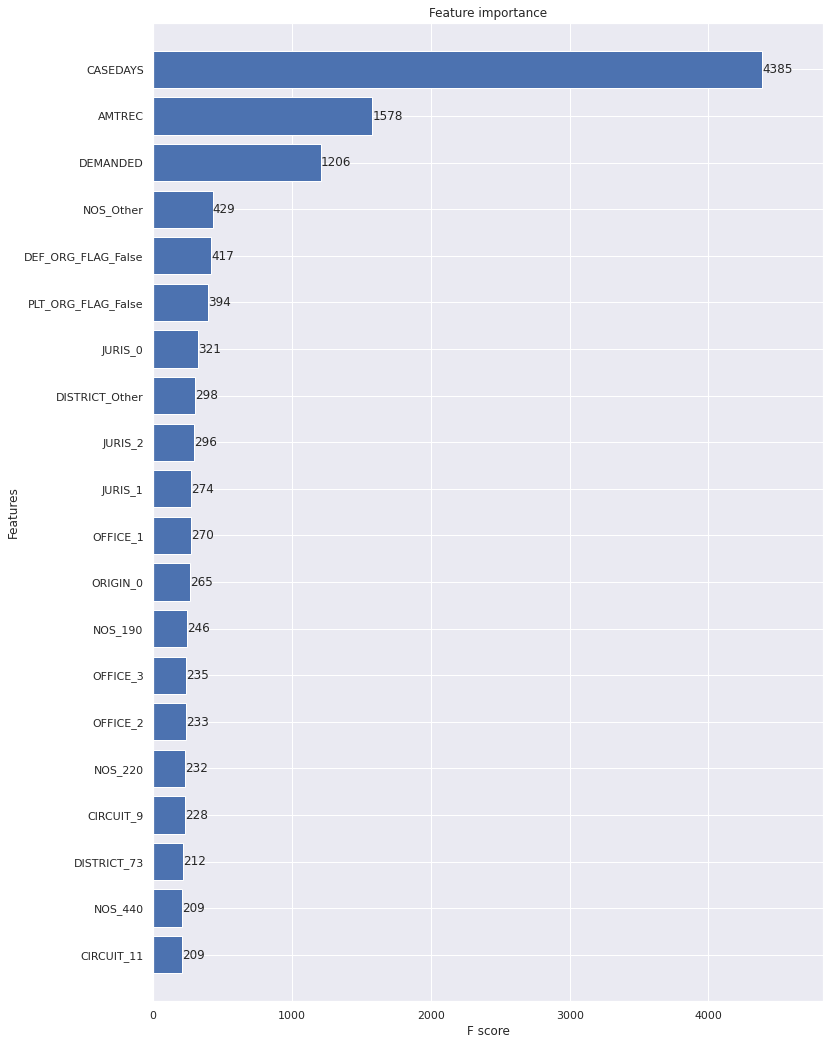

In [ ]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=20, height=0.8, ax=ax)
plt.show()